# Import Libraries

In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from pickle import dump
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from pickle import dump, load
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import warnings
from sklearn.exceptions import DataConversionWarning


# Import Data

In [22]:
url = "https://raw.githubusercontent.com/4GeeksAcademy/k-means-project-tutorial/main/housing.csv"
df = pd.read_csv(url)
df.to_csv("/workspaces/alfonsoMG_K-means/data/raw/raw_data.csv")
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


We have received data in the form of a .csv file, and our objective is to preprocess this data to address our specific problem. The dataset comprises various columns, but our focus is narrowed down to three key variables: longitude, latitude, and Median Income. To streamline the data and simplify our analysis, we will create a new dataframe exclusively containing these selected columns.

This refined dataframe, consisting of longitude, latitude, and Median Income, will serve as the primary dataset for the subsequent application of the K-Means clustering algorithm. The purpose of utilizing K-Means is to categorize the data into six distinct regions based on similarities in these specified features. This segmentation allows us to gain insights into patterns and relationships within the data, facilitating a more in-depth understanding of the underlying structures.

In [23]:
columns = ["Latitude", "Longitude", "MedInc"]
df = df[columns]
df.head()

,Latitude,Longitude,MedInc
0,37.88,-122.23,8.3252
1,37.86,-122.22,8.3014
2,37.85,-122.24,7.2574
3,37.85,-122.25,5.6431
4,37.85,-122.25,3.8462


# K-Means

To implement K-means, we also need to perform a train-test split. However, in this case, as the model is designed to provide us with a column, the procedure for obtaining this column will be different from supervised models. Specifically, the train-test split method will only return splits for the input data (X), and we will manually extract the corresponding output (Y) based on the classifications generated by the K-means model. In our specific scenario, we are dealing with six different classifications.

This means that after applying the train-test split to the input data, we will use the K-means model to classify the data into six distinct groups. Subsequently, we will manually extract these classifications as the output variable (Y) for both the training and testing datasets. This approach ensures that our model is appropriately trained and evaluated, taking into account the unique characteristics of unsupervised learning, where the algorithm identifies patterns and assigns labels without explicit reference to pre-existing target values.

### *Feature Selection*

In [24]:
X = df
X_train, X_test = train_test_split(X, test_size = 0.2, random_state = 24)

### *Model Training*

In [25]:
model = KMeans(n_clusters = 6, random_state = 24)
model.fit(X_train)

dump (model, open (f"/workspaces/alfonsoMG_K-means/models/k-means_model.pk", "wb"))

X_train["cluster"] = model.labels_
X_train.head()

/home/vscode/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,Latitude,Longitude,MedInc,cluster
19464,37.69,-120.97,3.4667,5
13265,34.10,-117.65,2.4667,0
5829,34.19,-118.30,4.9042,3
5111,33.96,-118.31,4.0625,0
19761,40.11,-122.17,1.7708,5


Our classification of the X_test data will be determined by applying the trained K-means model to predict cluster assignments for each data point in the test set. The clusters assigned by the model serve as our predicted classifications, reflecting the grouping patterns identified by K-means based on feature similarities. Unlike traditional supervised models, K-means does not predict explicit labels but assigns data points to clusters during the prediction process.

In [26]:
X_test["cluster"] = model.predict(X_test)

As the final step of this process, we will visually identify the classifications using Seaborn scatterplots. This approach allows us to compare, at a glance, the differences between our training and testing datasets. The primary purpose is to ensure that the division is coherent and to proceed to the last step with confidence. By visualizing the cluster assignments in scatterplots, we can quickly assess how well the model generalizes to new data and verify the consistency of the clustering patterns between the training and testing sets. This visual inspection serves as a valuable checkpoint before moving on to the final step of the analysis.

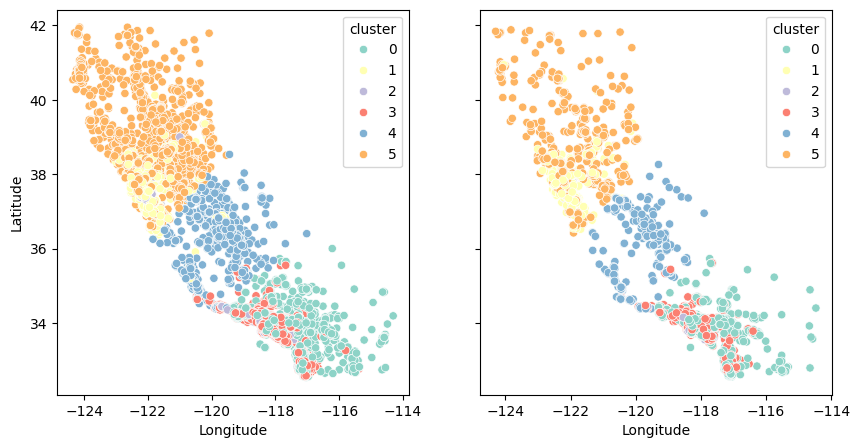

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

sns.scatterplot(data=X_train, x="Longitude", y="Latitude", hue="cluster", palette="Set3", ax=ax[0])
sns.scatterplot(data=X_test, x="Longitude", y="Latitude", hue="cluster", palette="Set3", ax=ax[1])

plt.show()

# Decision Tree

### *Feature Selection*

In [28]:
y_train = X_train["cluster"]
y_test = X_test["cluster"]
X_train = X_train.drop("cluster", axis = 1)
X_test = X_test.drop("cluster", axis = 1)

### *Best Model Search*

In [29]:
# Ignore specific data conversion warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Initialize empty list to store accuracy values
accs = []

# Define a list of percentages for feature selection
percents = [1, 0.8, 0.7, 0.6, 0.5]

# Loop through each percentage
for p in percents:
    # Create a SelectKBest model using ANOVA F-statistic for feature selection
    selection_model = SelectKBest(f_classif, k=int(len(X_train.columns) * p))
    
    # Fit the selection model to the training data
    selection_model.fit(X_train, y_train)

    # Get the indices of selected features
    ix = selection_model.get_support()

    # Transform the training set to include only selected features
    train_sel = pd.DataFrame(selection_model.transform(X_train), columns=X_train.columns.values[ix])

    # Save the selection model
    dump(selection_model, open(f"../models/selection_models/selection_model{p}.pk", "wb"))

    # Define a decision tree classifier
    model = DecisionTreeClassifier(random_state=24)

    # Train the decision tree model on the selected features
    model.fit(train_sel, y_train)

    # Make predictions on the training set
    y_pred = model.predict(train_sel)

    # Calculate and store accuracy
    acc = accuracy_score(y_train, y_pred)
    accs.append(acc)

# Find the index of the maximum accuracy
best_acc = accs.index(max(accs))

# Print the results
print(f'The best k for selection is {percents[best_acc]}.')
print(f'The best accuracy we get is {round(accs[best_acc], 4)}.')
print(accs)

The best k for selection is 1.
The best accuracy we get is 1.0.
[1.0, 0.9303536821705426, 0.9303536821705426, 0.693374515503876, 0.693374515503876]


### *Model Training*

In [30]:
# Load the pre-trained feature selection model
selection_model = pickle.load(open("/workspaces/alfonsoMG_K-means/models/selection_models/selection_model1.pk", "rb"))
ix = selection_model.get_support()

# Transform the training and training set to include only selected features
X_train_sel = pd.DataFrame(selection_model.transform(X_train), columns=X_train.columns.values[ix])
X_test_sel = pd.DataFrame(selection_model.transform(X_test), columns=X_test.columns.values[ix])

# Initialize a decision tree classifier and fit it
model = DecisionTreeClassifier(random_state=24)
model.fit(X_train_sel, y_train)

# Make predictions on the training set and calculate the accuracy
y_pred = model.predict(X_train_sel)
train_score = accuracy_score(y_train, y_pred)
print(f'The accuracy score for Train is {train_score}.')

# Make predictions on the testing set and calculate the accuracy
y_pred = model.predict(X_test_sel)
test_score = accuracy_score(y_test, y_pred)
print(f'The accuracy score for Test is {test_score}.')

# Calculate and print the difference in accuracy between the training and testing sets
difference = train_score - test_score
print(f'The accuracy difference between the models is {difference}.')

# Save the trained decision tree model
dump(model, open(f"/workspaces/alfonsoMG_K-means/models/decision_tree_default_model.pk", "wb"))

The accuracy score for Train is 1.0.
The accuracy score for Test is 0.9949127906976745.
The accuracy difference between the models is 0.005087209302325535.


# Conclusion